In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 77% 254M/331M [00:00<00:00, 746MB/s] 
100% 331M/331M [00:00<00:00, 753MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/utkface-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential
from keras.optimizers import Adam

In [5]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [6]:
age=[]
gender=[]
img_path=[]
for img in os.listdir(folder_path):
  age.append(int(img.split('_')[0]))
  gender.append(int(img.split('_')[1]))
  img_path.append(img)

In [7]:
len(age)

23708

In [8]:
df = pd.DataFrame({'age':age,'gender':gender,'img_path':img_path})

In [9]:
df.shape

(23708, 3)

In [10]:
df.head()

,age,gender,img_path
0,26,0,26_0_1_20170113181549340.jpg.chip.jpg
1,17,1,17_1_1_20170114030037010.jpg.chip.jpg
2,25,1,25_1_0_20170104234942017.jpg.chip.jpg
3,30,0,30_0_2_20170116170814123.jpg.chip.jpg
4,62,0,62_0_1_20170113182552751.jpg.chip.jpg


In [11]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1, random_state=0).iloc[20000:]

In [12]:
train_df.shape

(20000, 3)

In [13]:
test_df.shape

(3708, 3)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [15]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=folder_path,
        x_col='img_path',
        y_col=['age','gender'],
        target_size=(200, 200),
        class_mode='multi_output')

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=folder_path,
    x_col='img_path',
    y_col=['age','gender'],
    target_size=(200, 200),
    class_mode='multi_output')

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [17]:
vggnet = VGG16(
    include_top = False,
    input_shape=(200,200,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [18]:
vggnet.trainable = False

output = vggnet.layers[-1].output
# last layer output of vggnet is being stored in output variable i.e of conv layers

flatten = Flatten()(output)

# dense 1,3 will predict age and parallelly 2,4 will predict gender
dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)

dense3 = Dense(512,activation='relu')(dense1)
dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

model = Model(inputs=vggnet.input,outputs=[output1,output2])

In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 12, 12,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 12, 12,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 12, 12,    │  2,359,808 │ block5_conv1[0][

 Total params: 34,116,418 (130.14 MB)

 Trainable params: 19,401,730 (74.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

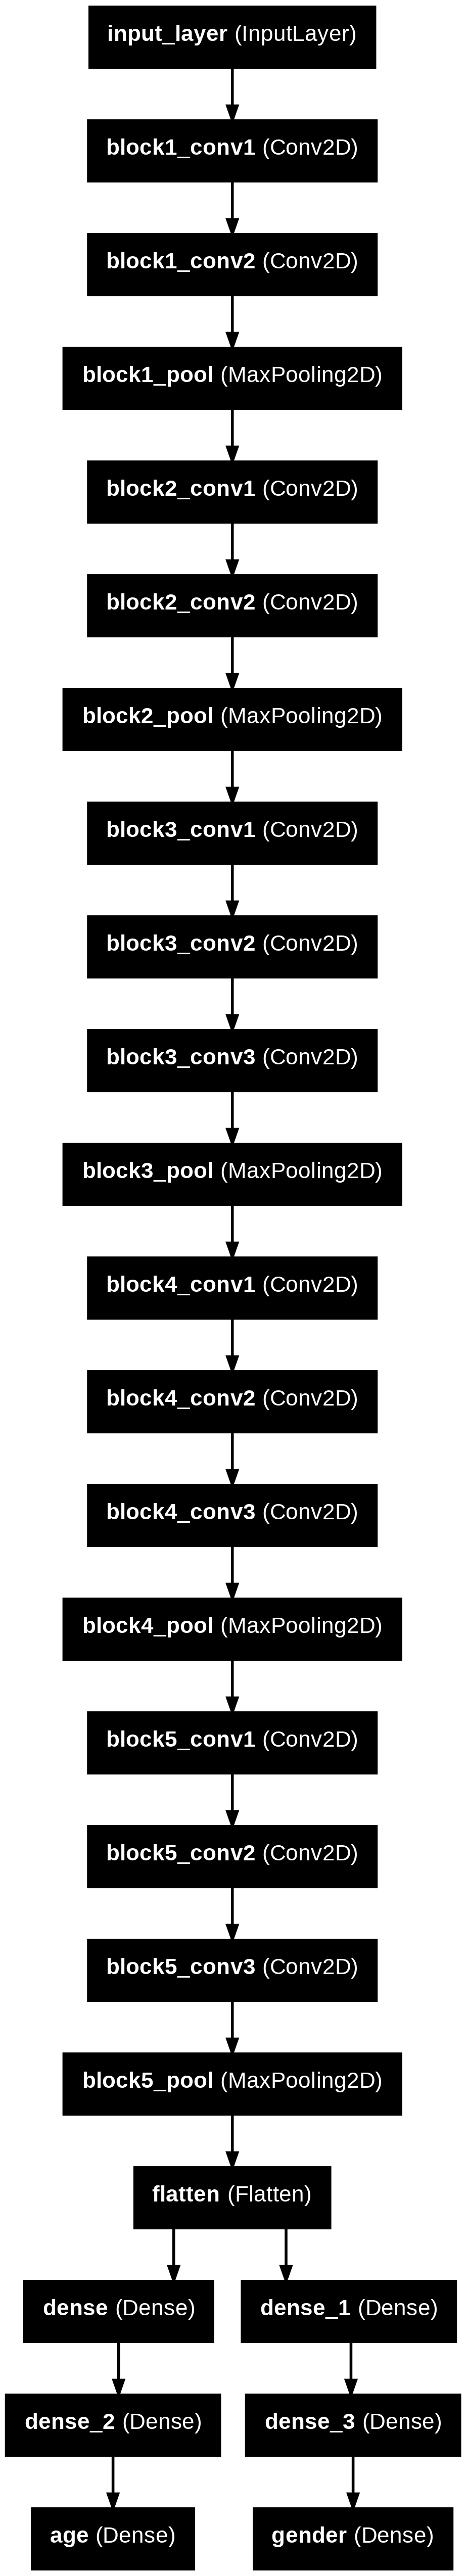

In [20]:
from keras.utils import plot_model
plot_model(model, show_layer_names=True)

In [21]:
def custom_generator(generator):
    while True:
        x, y = next(generator)
        # y is a list of arrays when y_col is a list and class_mode is multi_output
        # We need to convert this to a dictionary
        if isinstance(y, list):
            labels_dict = {'age': y[0], 'gender': y[1]}
            yield x, labels_dict
        else:
            yield x, y

In [22]:
# Use the custom generator for training and validation
train_dataset = custom_generator(train_generator)
test_dataset = custom_generator(test_generator)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = test_generator.samples // test_generator.batch_size

model.compile(optimizer='adam',
              loss={'age':'mae','gender':'binary_crossentropy'},
              metrics={'age':'mae', 'gender':'accuracy'},
                       loss_weights={'age':1, 'gender':99})

In [23]:
history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=10,
        validation_data=test_dataset,
        validation_steps=validation_steps)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 394ms/step - age_loss: 12.4332 - age_mae: 12.4332 - gender_accuracy: 0.6768 - gender_loss: 0.6795 - loss: 79.6991 - val_age_loss: 9.6551 - val_age_mae: 9.6551 - val_gender_accuracy: 0.8234 - val_gender_loss: 0.3824 - val_loss: 47.5082
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 262s 419ms/step - age_loss: 9.3095 - age_mae: 9.3095 - gender_accuracy: 0.7841 - gender_loss: 0.4467 - loss: 53.5320 - val_age_loss: 8.4416 - val_age_mae: 8.4416 - val_gender_accuracy: 0.8459 - val_gender_loss: 0.3448 - val_loss: 42.5808
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 274s 439ms/step - age_loss: 9.2078 - age_mae: 9.2078 - gender_accuracy: 0.8019 - gender_loss: 0.4181 - loss: 50.5970 - val_age_loss: 8.3350 - val_age_mae: 8.3372 - val_gender_accuracy: 0.8490 - val_gender_loss: 0.3374 - val_loss: 41.7281
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 239s 383ms/step - age_loss: 8.9581 - age_mae: 8.9581 - gender_accuracy: 0.8127 - gender_loss: 0.3984 - loss: 48.3968 - val_a

In [27]:
# Save model into runtime / drive first
model.save('age_gender_multi_pred.keras')
# or
#model.save('my_keras_model.h5')

# save to my computer
from google.colab import files
files.download('age_gender_multi_pred.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Load the model from runtime

loaded_model = keras.models.load_model('age_gender_multi_pred.keras')

# #load from my computer
# from google.colab import files
# # 1. Upload the file. This returns a dictionary of uploaded files.
# uploaded_dict = files.upload()

# # 2. Get the name of the uploaded file.
# #    'uploaded_dict.keys()' gives us the names of all uploaded files. only uploaded one file, so the first key.
# model_filename = list(uploaded_dict.keys())[0]
# print(f"Uploaded model: {model_filename}")

# # 3. Now, load the model using the filename (a string).
# loaded_model = keras.models.load_model(model_filename)
# print("Model loaded successfully!")

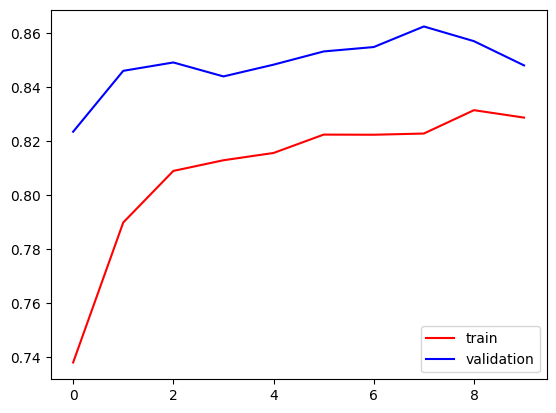

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['gender_accuracy'],color='red',label='train')
plt.plot(history.history['val_gender_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

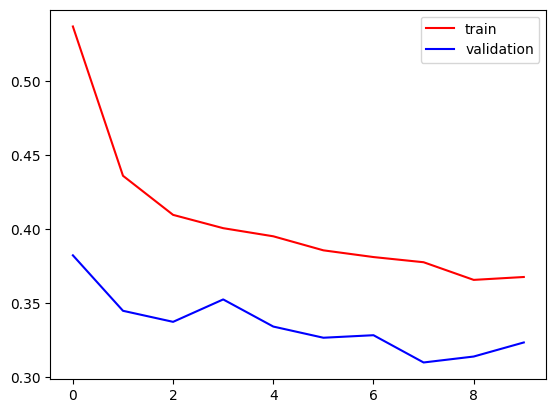

In [26]:
plt.plot(history.history['gender_loss'],color='red',label='train')
plt.plot(history.history['val_gender_loss'],color='blue',label='validation')
plt.legend()
plt.show()

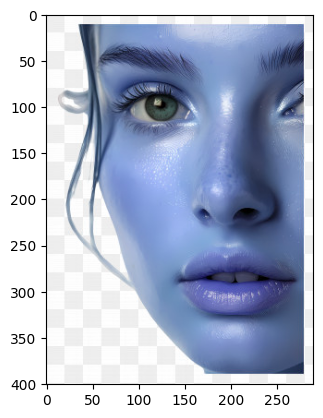

In [70]:
# Prediction by saved model on any human face
import matplotlib.pyplot as plt
import cv2

test_img = cv2.imread('/content/human_face2.jpeg')
plt.imshow(test_img)

In [71]:
# reshape to our req shape i.e 200x200
print(test_img.shape)
test_img = cv2.resize(test_img,(200,200))
print(test_img.shape)
# input of our model
test_input = test_img.reshape((1,200,200,3))

(401, 290, 3)
(200, 200, 3)


In [72]:
# model's prediction on age and gender
result = model.predict(test_input)

# convert model prediction to readable format
def interpret_prediction(prediction):
    """
    Takes the raw model output and returns a human-readable string.
    Assumes:
        - prediction[0] is age
        - prediction[1] is gender (0 = Male, 1 = Female)
    """
    age = prediction[0][0][0] # Extract the scalar age value
    gender_confidence = prediction[1][0][0] # Extract the scalar gender confidence

    # Convert gender confidence to a label
    if gender_confidence < 0.5:
        gender_label = "Male"
        # Calculate confidence percentage for the predicted class (Male)
        confidence_percentage = (1 - gender_confidence) * 100
    else:
        gender_label = "Female"
        # Calculate confidence percentage for the predicted class (Female)
        confidence_percentage = gender_confidence * 100

    # Format the final result
    result_string = f"Prediction: A {age:.1f} year old {gender_label} (Confidence: {confidence_percentage:.1f}%)"
    return result_string

# Use the function
print(interpret_prediction(result))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: A 24.6 year old Female (Confidence: 100.0%)
